<a href="https://colab.research.google.com/github/GubioGL/Optics/blob/main/Mult_modos_%C3%A2ngulos_diferentes_2_0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade LightPipes
from LightPipes import *
from matplotlib import image
from scipy.fft import fft2, ifft2 ,fftshift
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import PIL
from PIL import Image

     |████████████████████████████████| 50 kB 1.1 MB/s 


In [ ]:
########################################################################
P = 1 
L = 1
n = 2**10 + 1
lamb = 512*nm        
k = 2*np.pi/lamb        
w_0 = 1.6*mm          
z_R = np.pi*w_0**2/lamb 
########################################################################
dx = 17*um  
x = np.arange(-n/2+1, n/2,1)*dx
y = np.arange(-n/2+1, n/2,1)*dx
xx,yy = np.meshgrid(x,y)
########################################################################
dzPar = np.arange(1e-20,100,1)*cm  
z = dzPar[0]       
###############################################################################
r    = np.sqrt(xx**2+yy**2)                                                 
C    = np.sqrt(2*np.math.factorial(P)/(np.pi*np.math.factorial(P+abs(L))))  
w    = w_0*np.sqrt(1+(z/z_R)**2)
R    = z*(1+(z_R/z)**2)
phi  = (1+2*P+abs(L))*np.arctan(z/z_R)  
PL   = scipy.special.assoc_laguerre(2*r**2/w**2,P,abs(L))
Fase = np.exp( -r**2/w**2 - 1j*k*r**2/(2*R) + 1j*phi - 1j*L*np.arctan2(yy,xx) )*np.exp(-1j*k*z)
LG = C*w_0/w*(r*np.sqrt(2)/w)**abs(L)*PL*Fase
##############################################################################

########################################################################
F = Begin(2*abs(x[1]),lamb,n);
FinL = F.copy(F)
FinL.field = LG

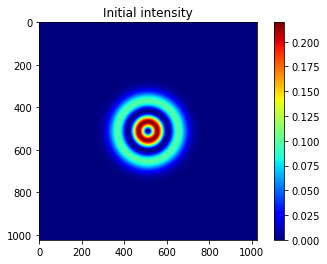

In [ ]:
img = Intensity(0,FinL); 
plt.imshow(img,cmap='jet'); plt.title('Initial intensity');plt.colorbar()
plt.show()

Mounted at /content/drive


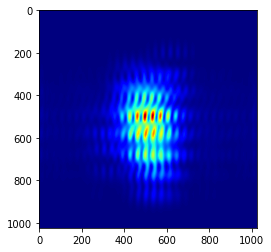

In [ ]:
########################################################################
theta_coh = 3e-4
N_inc     = 30
Tx = theta_coh*np.random.standard_normal(N_inc)
Ty = theta_coh*np.random.standard_normal(N_inc)
Nx = n-1
w = np.arange(-Nx/2,Nx/2,1)*dx  # pergunta sobre o dx
[wx,wy] = np.meshgrid(w,w)
#########################################################################
##### Pedidno permissão para ter acesso ao drive
from google.colab import drive
drive.mount('/content/drive', True)
SLM  = Image.open('/content/drive/MyDrive/Colab Notebooks/Gubio/DD.png')

imgGray = SLM.convert('L')
imgGray.save('imgGray2.jpg')
imgGra  = plt.imread('imgGray2.jpg')
ri = imgGra/imgGra.max()

### Calculo da onda no plano de saida 
i=0
SI = [0] 

while (i<N_inc):
  i+=1
  E = np.exp(np.pi*2j*(Tx[i-1]*k*wx + Ty[i-1]*k*wy))
  FAng = F.copy(F) 
  FAng.field = FinL.field*E    # colocando  o ângulo no campo

  Fprop = Forvard(10*cm,FAng) # Propaga até a Inter.
  EE = Fprop.field*ri          # Add a interfência 
  Fint = F.copy(F)             # Criar um  Campo no Lightpipes
  Fint.field = EE              # Escrevendo o Campo que sai da Inter.
  
  Fprop = Forvard(60*cm,Fint)  # Propaga até o plano de Observação
  FpropInt = Intensity(0,Fprop)
                               # plt.imshow(FpropInt,cmap='jet')
                               # plt.show()
  SI  = SI + FpropInt          # Somando todas as interferência   
imagem = SI/N_inc              # Perguntar a Nara
plt.imshow(imagem,cmap='jet')
plt.show()  

In [ ]:
# Ajustado para analisar na Direita e esquerda
### Função da Suavização #########################
def SUAVE(media, linha):
  novalista = []
  for i in range(media ,1024,1):
    b = imagem[linha,i-media:i]
    AA = sum(b)/media
    novalista.append(AA)
  return np.array(novalista)

def MM(suavizar,linha):
  maxi2 = SUAVE(suavizar,linha).max()
  posiçao2 = 0
  for i in SUAVE(suavizar,linha):
    if i == maxi2:
      break 
    posiçao2 +=1 

#### Encontrar o valor mínimo local a Direita parti do maximo global
  mini = 0
  Vimax = SUAVE(suavizar,linha)[posiçao2:1024]
  for i in range(len(Vimax)):
    if i == len(Vimax)-1:
      break
    if Vimax[i] > Vimax[i+1]:
      mini = Vimax[i+1]
    elif Vimax[i] < Vimax[i+1]:
      mini = Vimax[i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMin = 0 
  for i in Vimax:
    if i == mini:
      break 
    PMin += 1  
  posiçaomin = posiçao2 + PMin -1
#######################################################################
#### Encontrar o valor mínimo local a ESQUERDA a parti do maximo lobal
  miniE = 0
  xamiV = SUAVE(suavizar,linha)[0:posiçao2]
#########################################################
  for i in range(len(xamiV)):
    i += 1
    if i == len(xamiV)-1:
      break
    if xamiV[-i] > xamiV[-i-1]:
      miniE = xamiV[-i-1]
    elif xamiV[-i] < xamiV[-i-1]:
      miniE = xamiV[-i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMinE = 0 
  for i in range(len(xamiV)):
    i+=1
    if xamiV[-i] == miniE: 
      break 
    PMinE += 1  
  posiçaominE = posiçao2 - PMinE

  if miniE > mini:
    posiçaomin = posiçaominE
    mini       = miniE
  # [0] = Valor max,[1] = Posição max ,[2] = Valor Min,[3] = Posição Min
  return maxi2, posiçao2, mini, posiçaomin  #,miniE, posiçaominE 

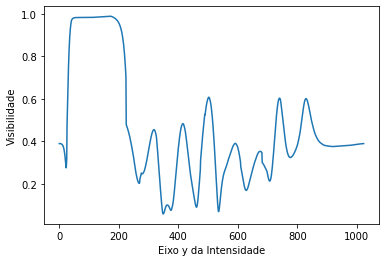

In [ ]:
# A VISIBILIDADE TODA
VisibilidadeN = []

for j in range(0,1024):
  V = ( MM(2,j)[0]-MM(2,j)[2])/(MM(2,j)[0]+MM(2,j)[2])
  VisibilidadeN.append(V) 
  
plt.plot(VisibilidadeN) 
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()


(0.0019137626149589948, 530, 0.0008964784130012116, 513)


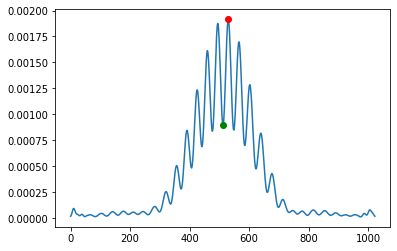

Visibilidade = 0.36199179779827345


In [ ]:
qe =2

qw = 330
print(MM(qe,qw))

# DISTRIBUIÇÃO DE INTENSIDADE

plt.plot(imagem[qw])
plt.plot(MM(qe,qw)[1] , MM(qe,qw)[0] , 'o', color ='red'  )
plt.plot(MM(qe,qw)[3] , MM(qe,qw)[2] , 'o', color ='green'  )

plt.show()

# VISIBILIDADE

V = ( MM(qe,qw)[0]  - MM(qe,qw)[2] )/( MM(qe,qw)[0]  + MM(qe,qw)[2])
print("Visibilidade =",V)